## House Prices - Advanced Regression Techniques

#### Задача - предсказать стоимость дома по его характеристикам

In [128]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeCV
import xgboost as xgb


%matplotlib inline

In [166]:
df_test = pd.read_csv('test.csv') # тестовые данные
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

 * Всего в данных 1459 наблюдений

 * Всего `80` признаков, которые нужно проанализировать, чтоб сделать о цене дома. 
 
 * Причем много фич имеют пропущенные значения

#### Выгрузим тренировочные данные

In [130]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [131]:
Sale = df_train['SalePrice']

 * Всего в данных 1460 наблюдений

 * Всего `81` признак, которые нужно проанализировать, чтоб сделать о цене дома. 
 
 * Причем много фич имеют пропущенные значения

In [132]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Посчитаем сколько пропущенных значений в каждом из признаков и наглядно посмотрим на гистограмме

In [133]:
null_values = df_train.isnull().sum().sort_values(ascending=False)
null_values = null_values[null_values > 0]
null_values

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

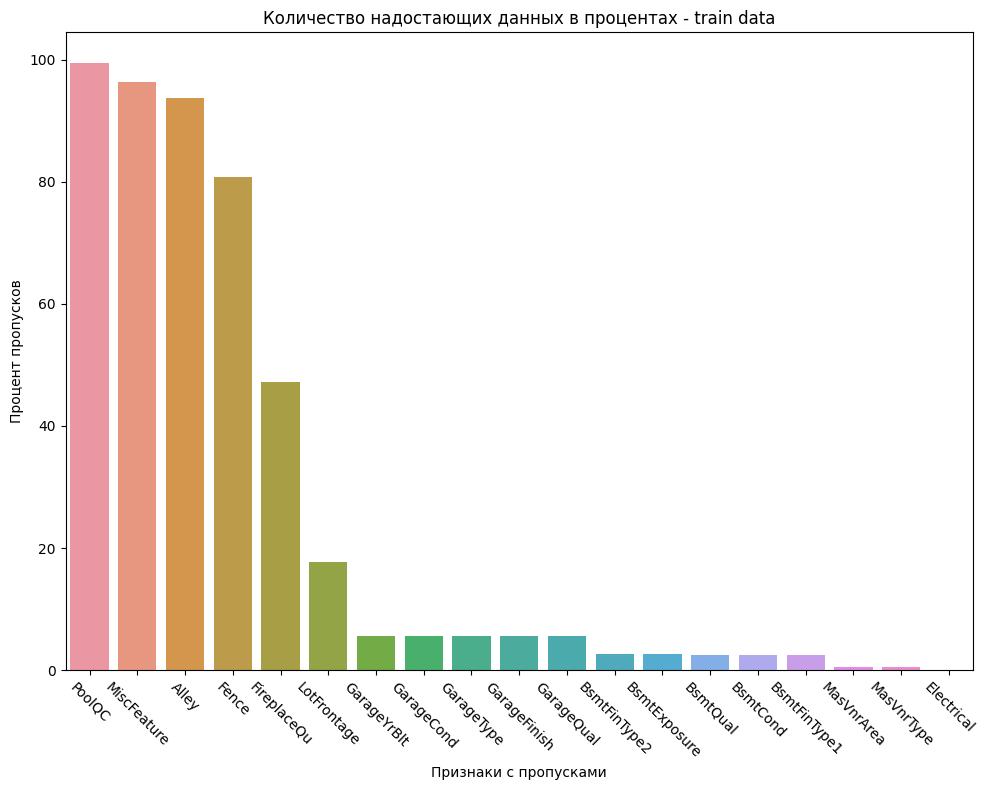

In [43]:
proc = null_values / df_train.shape[0] * 100

plt.figure(figsize=(10, 8))
sns.barplot(x=proc.index, y=proc.values)

plt.title("Количество надостающих данных в процентах - train data")
plt.xlabel("Признаки с пропусками")
plt.ylabel("Процент пропусков")
plt.xticks(rotation=-45)
plt.tight_layout()

Как в тестовых так и в тренировочных данных наблюдается большое количество пропусков

Объединим датасеты в один, чтоб избавится от пропусков и ненужных столбцов во всех данных

In [134]:
all_data = pd.concat([df_train.iloc[:,:-1], df_test],axis=0)
all_data = all_data.drop(columns=['Id'], axis=1) #удаляем, так как не несет никакой информации

In [135]:
def missing_values(df, name):
    null_values = df.isnull().sum().sort_values(ascending=False)
    null_values = null_values[null_values > 0]
    proc = null_values / df.shape[0] * 100

    plt.figure(figsize=(10, 8))
    sns.barplot(x=proc.index, y=proc.values)

    plt.title(f"{name} Количество надостающих данных в процентах - all data")
    plt.xlabel("Признаки с пропусками")
    plt.ylabel("Процент пропусков")
    plt.xticks(rotation=-45)
    plt.tight_layout()
    print(proc.index)

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'Functional', 'BsmtHalfBath',
       'BsmtFullBath', 'Utilities', 'SaleType', 'BsmtFinSF1', 'KitchenQual',
       'GarageCars', 'BsmtUnfSF', 'TotalBsmtSF', 'Exterior2nd', 'Exterior1st',
       'GarageArea', 'Electrical', 'BsmtFinSF2'],
      dtype='object')


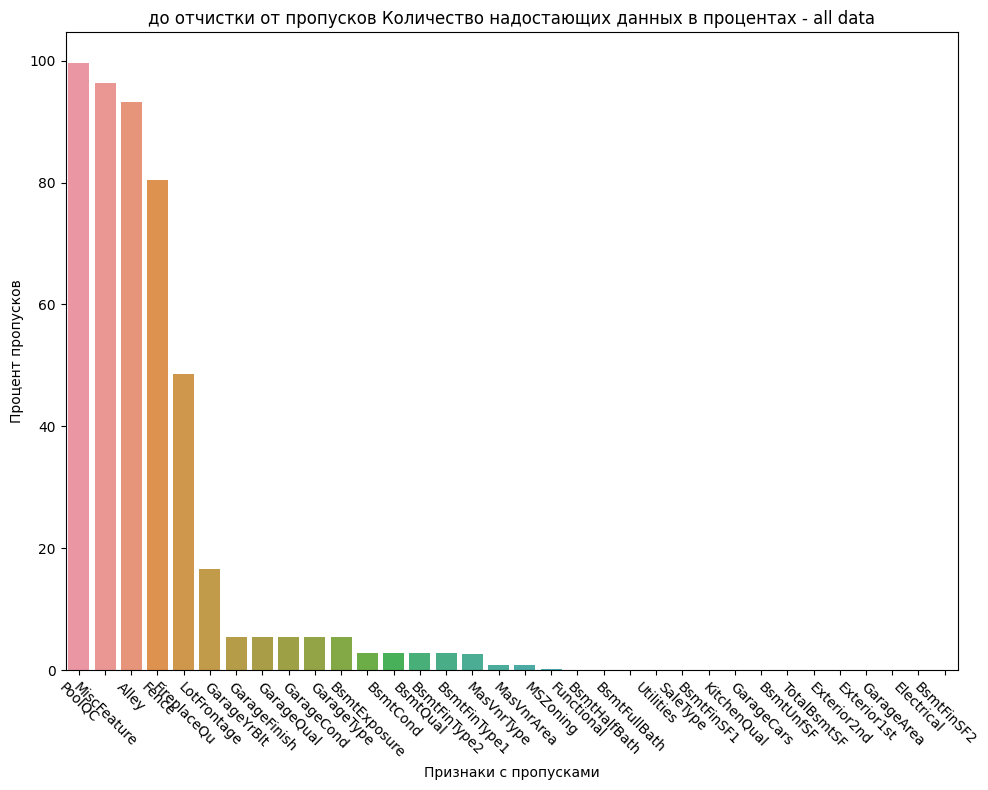

In [54]:
missing_values(all_data, "до отчистки от пропусков")

'Exterior2nd', 'Exterior1st',
 'Electrical', 'BsmtFinSF2'],

* PoolQC: Pool quality
     * NA	No Pool
* MiscFeature: Miscellaneous feature not covered in other categories
     * NA	None
* Alley: Type of alley access to property
     * NA 	No alley access
* Fence: Fence quality
     * NA	No Fence
* FireplaceQu: Fireplace quality
     * NA	No Fireplace
* LotFrontage: Linear feet of street connected to propert
* GarageYrBlt: Year garage was built
    * GarageFinish, GarageQual, GarageCond, GarageType
        * NA	No Garage
    * GarageCars, GarageArea
* BsmtExposure: Refers to walkout or garden level walls
    * NA	No Basement
    * BsmtCond, BsmtQual, BsmtFinType2, BsmtFinType1
        * NA	No Basement
    * BsmtFinType1, BsmtUnfSF, TotalBsmtSF, BsmtFinSF2, BsmtHalfBath, BsmtFullBath
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* MSZoning: Identifies the general zoning classification of the sale.
* Functional: Home functionality (Assume typical unless deductions are warranted)
* Utilities: Type of utilities available
* SaleType: Type of sale
* KitchenQual: Kitchen quality
* Exterior2nd: Exterior covering on house (if more than one material)
* Exterior1st: Exterior covering on house
* Electrical: Electrical system


На основе проанализированных пунктов заполним часть пропусков и посмотрим 

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'MSZoning', 'Utilities',
       'Functional', 'Exterior2nd', 'SaleType', 'Electrical', 'Exterior1st',
       'KitchenQual'],
      dtype='object')


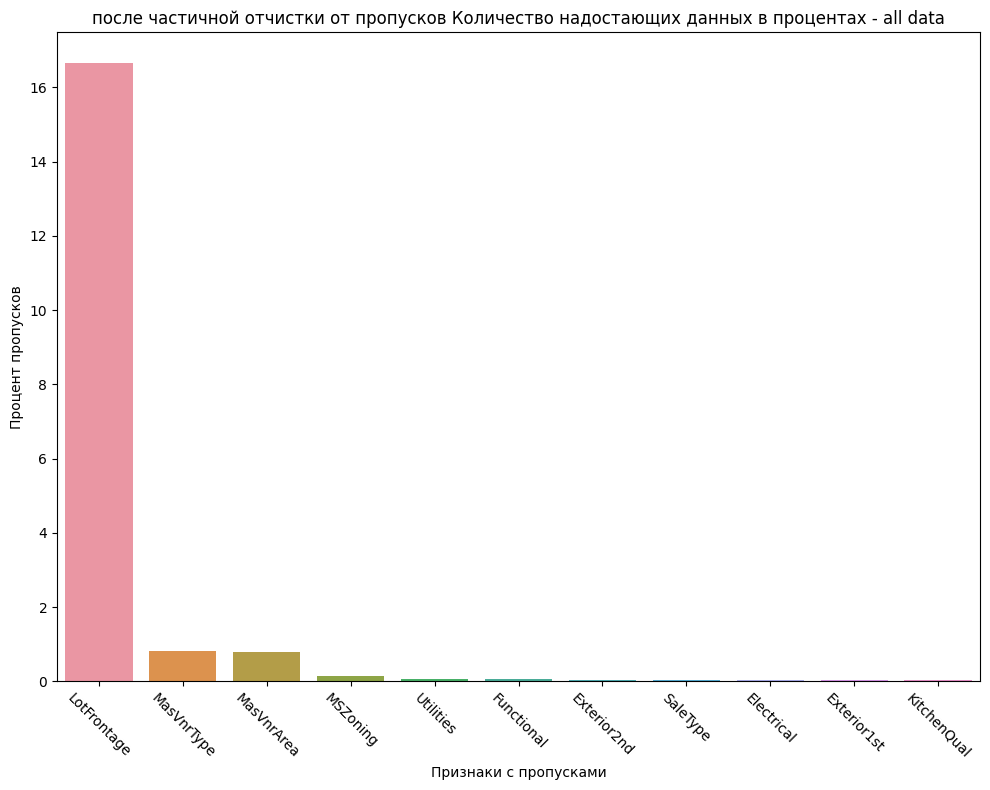

In [136]:
all_data['PoolQC'].fillna('No Pool', inplace=True)
all_data['MiscFeature'].fillna('No Feature', inplace=True)
all_data['Alley'].fillna('No alley access', inplace=True)
all_data['Fence'].fillna('No Fence', inplace=True)
all_data['FireplaceQu'].fillna('No Fireplace', inplace=True)

columns = ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']
for col in columns:
    all_data[col].fillna('No Garage', inplace=True)
    
all_data['GarageCars'] = np.where(all_data['GarageQual'] == 'No Garage', 0, all_data['GarageCars'])
all_data['GarageArea'] = np.where(all_data['GarageQual'] == 'No Garage', 0, all_data['GarageArea'])
all_data['GarageYrBlt'] = np.where(all_data['GarageQual'] == 'No Garage', 0, all_data['GarageYrBlt'])


columns = ['BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']
for col in columns:
    all_data[col].fillna('No Basement', inplace=True)
    
all_data['BsmtFinSF1'] = np.where(all_data['BsmtExposure'] == 'No Basement', 0, all_data['BsmtFinSF1'])
all_data['BsmtUnfSF'] = np.where(all_data['BsmtExposure'] == 'No Basement', 0, all_data['BsmtUnfSF'])
all_data['TotalBsmtSF'] = np.where(all_data['BsmtExposure'] == 'No Basement', 0, all_data['TotalBsmtSF'])
all_data['BsmtFinSF2'] = np.where(all_data['BsmtExposure'] == 'No Basement', 0, all_data['BsmtFinSF2'])
all_data['BsmtHalfBath'] = np.where(all_data['BsmtExposure'] == 'No Basement', 0, all_data['BsmtHalfBath'])
all_data['BsmtFullBath'] = np.where(all_data['BsmtExposure'] == 'No Basement', 0, all_data['BsmtFullBath'])


missing_values(all_data, "после частичной отчистки от пропусков")

Были заполнены NULL - значения на основе описания данных

In [137]:
all_data['LotFrontage'].unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.,  26.,  25., 119.,  31.,  28., 117., 113., 125., 135., 136.,
        22., 123., 195., 155., 126., 200., 131., 133.])

Заполним значения LotFrontage на основе медианных значений

In [138]:
median_frontage = all_data['LotFrontage'].median()
all_data['LotFrontage'].fillna(median_frontage, inplace=True)

Помотрим MasVnrType и MasVnrArea совместно

In [139]:
all_data['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [140]:
result = all_data[all_data[['MasVnrType', 'MasVnrArea']].isnull().any(axis=1)]
print(result[['MasVnrType', 'MasVnrArea']])

     MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN
231         NaN         NaN
246         NaN         NaN
422         NaN         NaN
532         NaN         NaN
544         NaN         NaN
581         NaN         NaN
851         NaN         NaN
865         NaN         NaN
880         NaN         NaN
889         NaN         NaN
908         NaN         NaN
1132        NaN         NaN
1150        NaN       198.0
1197        NaN         NaN
1226        NaN         NaN
1402        NaN         NaN


In [141]:
all_data['MasVnrType'].fillna('unknown', inplace=True)
median_MasVnrArea = all_data['MasVnrArea'].median()
all_data['MasVnrArea'].fillna(median_frontage, inplace=True)

In [142]:
all_data['MSZoning'].fillna('unknown', inplace=True)
all_data['Utilities'].fillna('No Utilities', inplace=True)
all_data['Functional'].fillna('unknown', inplace=True)
all_data['Electrical'].fillna('No Electrical', inplace=True)

Посмотрим как соотносятся пропущенные значения оценки кухни и ее площади

In [143]:
result = all_data[all_data[['KitchenQual', 'KitchenAbvGr']].isnull().any(axis=1)]
print(result[['KitchenQual', 'KitchenAbvGr']])

   KitchenQual  KitchenAbvGr
95         NaN             1


In [144]:
all_data['KitchenAbvGr'].unique()

array([1, 2, 3, 0], dtype=int64)

Теперь посмотрим чему в среднем равен KitchenQual для KitchenAbvGr = 1

In [145]:
result = all_data[all_data['KitchenAbvGr'] == 1]
com_kitchen_qual = result['KitchenQual'].mode()[0]
print(com_kitchen_qual)


TA


In [146]:
all_data['KitchenQual'].fillna('TA', inplace=True)

Посмотрим как соотносятся nan-значения для Exterior1st и Exterior2nd

In [147]:
result = all_data[all_data[['Exterior1st', 'Exterior2nd']].isnull().any(axis=1)]
print(result[['Exterior1st', 'Exterior2nd']])

    Exterior1st Exterior2nd
691         NaN         NaN


Как видим, что для 691 id оба пропуска для одного значения, поэто заполним их одинаковым значением. Предположим, что это more then 3 material

In [148]:
all_data['Exterior1st'].fillna('more then 3 material', inplace=True)
all_data['Exterior2nd'].fillna('more then 3 material', inplace=True)

Index(['SaleType'], dtype='object')


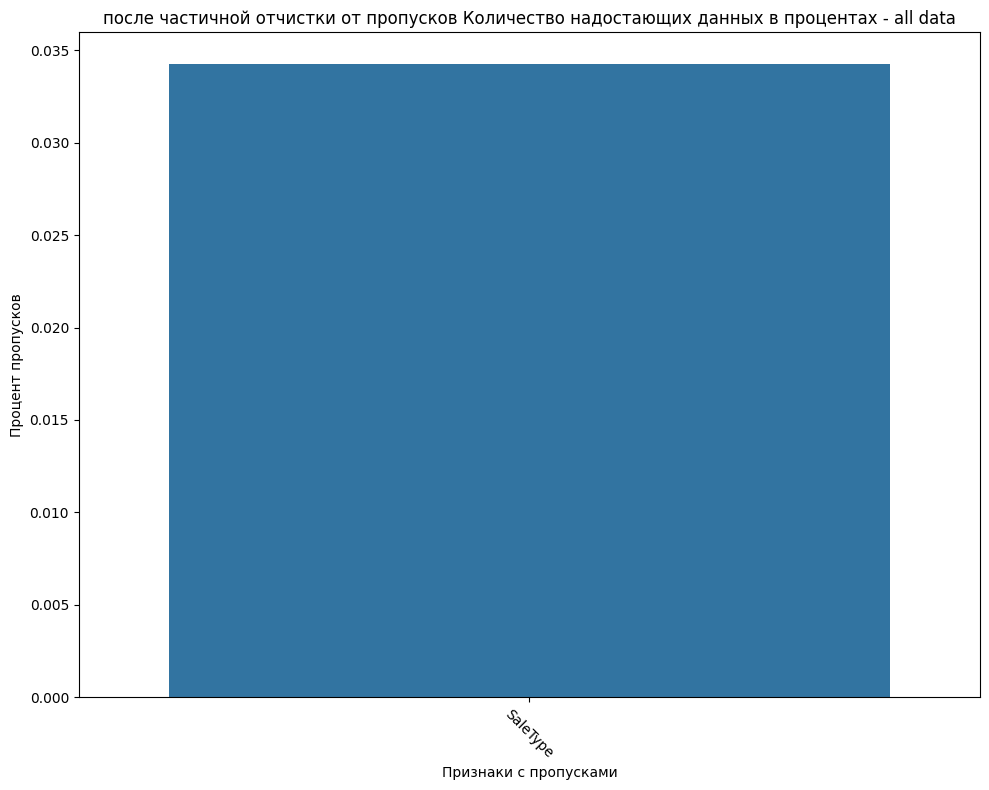

In [149]:
missing_values(all_data, "после частичной отчистки от пропусков")

Теперь осталось заполнить только SaleType 

In [150]:
all_data['SaleType'].fillna('unknown', inplace=True)

Закодируем признаки с помощью OneHotEncoding

In [157]:
def getObjectColumns(df):
    return [cname for cname in df.columns if df[cname].dtype == "object"]

def PerformOneHotEncoding(df, columnsToEncode):
    return pd.get_dummies(df, columns=columnsToEncode)

cat_cols = getObjectColumns(all_data)
all_data = PerformOneHotEncoding(all_data, cat_cols)
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_unknown,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,0,0,0,0,0,1,0


Теперь разъединим данные на тестовые и тренировочные обратно

In [159]:
train_data = all_data.iloc[:1460, :]
test_data = all_data.iloc[1460:, :]
df_train.shape

(1460, 310)

In [110]:
df_train['SalePrice'] = Sale

#### Помотрим на цены домов представленных в выборке

In [111]:
# посмотрим на описательные статистики
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Минимальная цена не отрицательна, так что можно говорить о корректности данных. 

Цена домов имеет большой разброс, интересно посмотреть на распределение этой величины

<Axes: xlabel='SalePrice', ylabel='Density'>

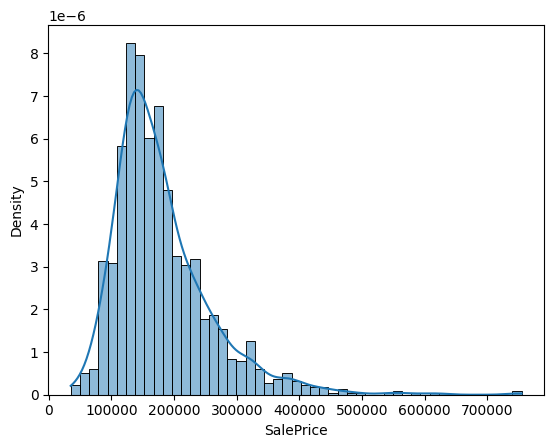

In [9]:
sns.histplot(data=df_train, x='SalePrice', stat='density', kde=True)

По полученно гистограмме видем, что в данных есть сильные выбросы, с ними нужно что-то сделать

Посчитаем асимметрию и эксцесс

In [12]:
print("Ассиметрия: %f" % df_train['SalePrice'].skew())
print("Эксцесс: %f" % df_train['SalePrice'].kurt())

Ассиметрия: 1.882876
Эксцесс: 6.536282


Эти данные говорят нам о том, что пик смещен влево, а пик острее, чем у нормального распределения

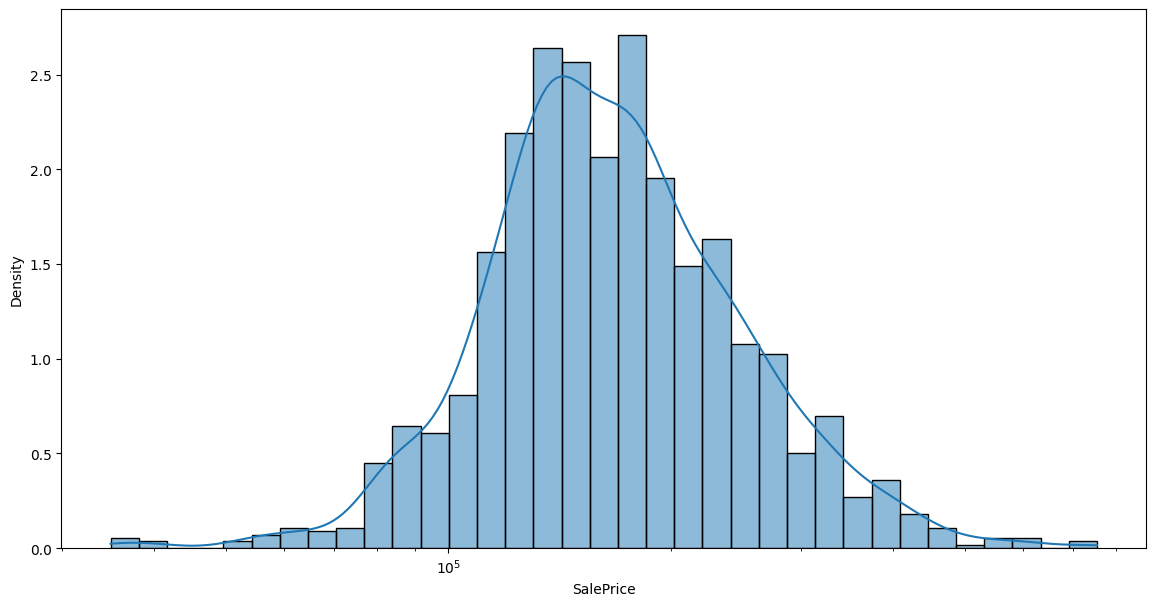

In [26]:
plt.figure(figsize = (14,7))
sns.histplot(data=df_train, x='SalePrice', stat='density', kde=True, log_scale=10);

Видим, что логарифмирование исправит ситуацию.

Для наглядности построим вероятностный (квантильный) график для изначальных данных и прологорифмированных, чтобы посмотреть, насколько хорошо выборка данных соответствует нормальному распределению.

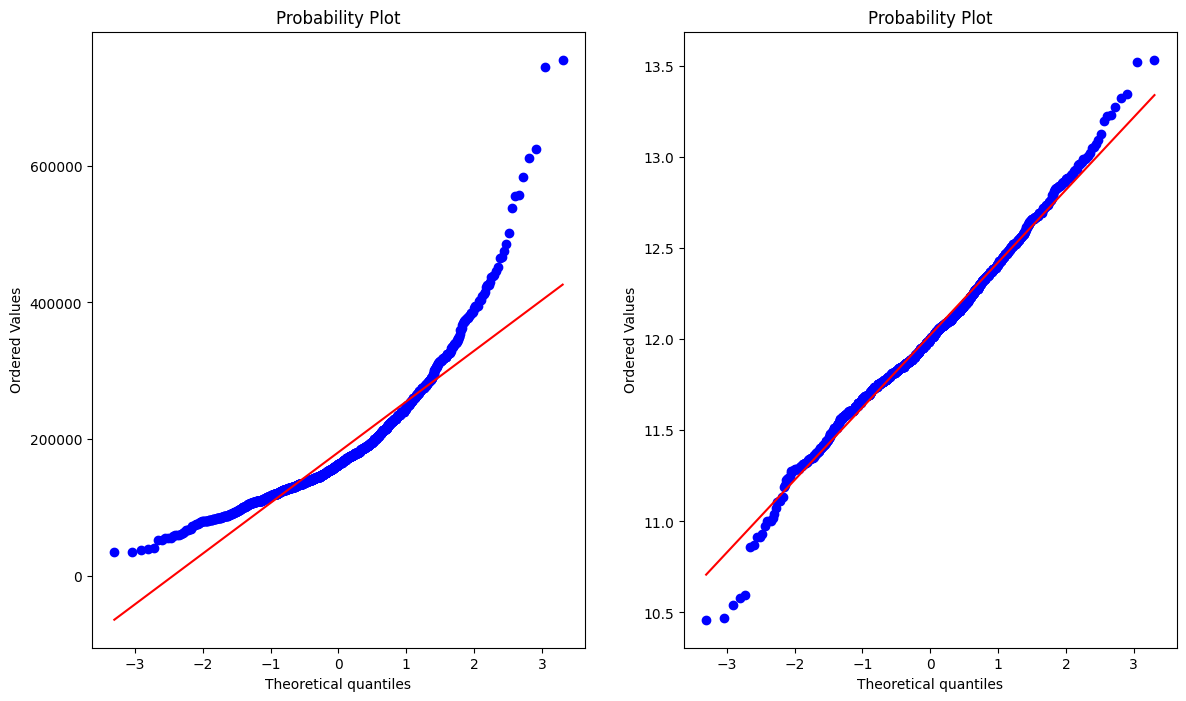

In [16]:
fig = plt.figure(figsize = (14,8))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['SalePrice'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['SalePrice']), plot=plt)

Убедившись в положительном результате, мы можем применить логарифмирование к данным

In [112]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

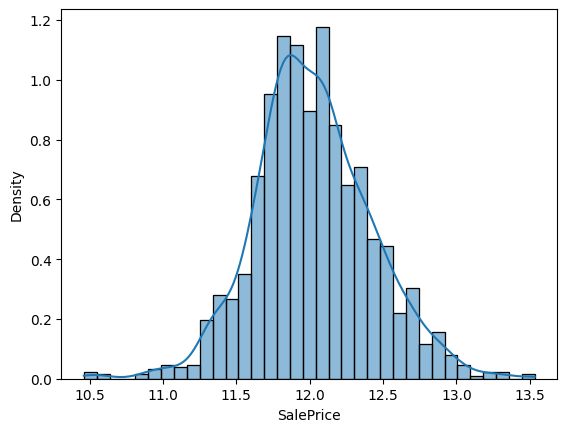

In [113]:
sns.histplot(data=df_train, x='SalePrice', stat='density', kde=True);

#### Теперь помотрим с какими признаками коррелирует наша целевая переменная

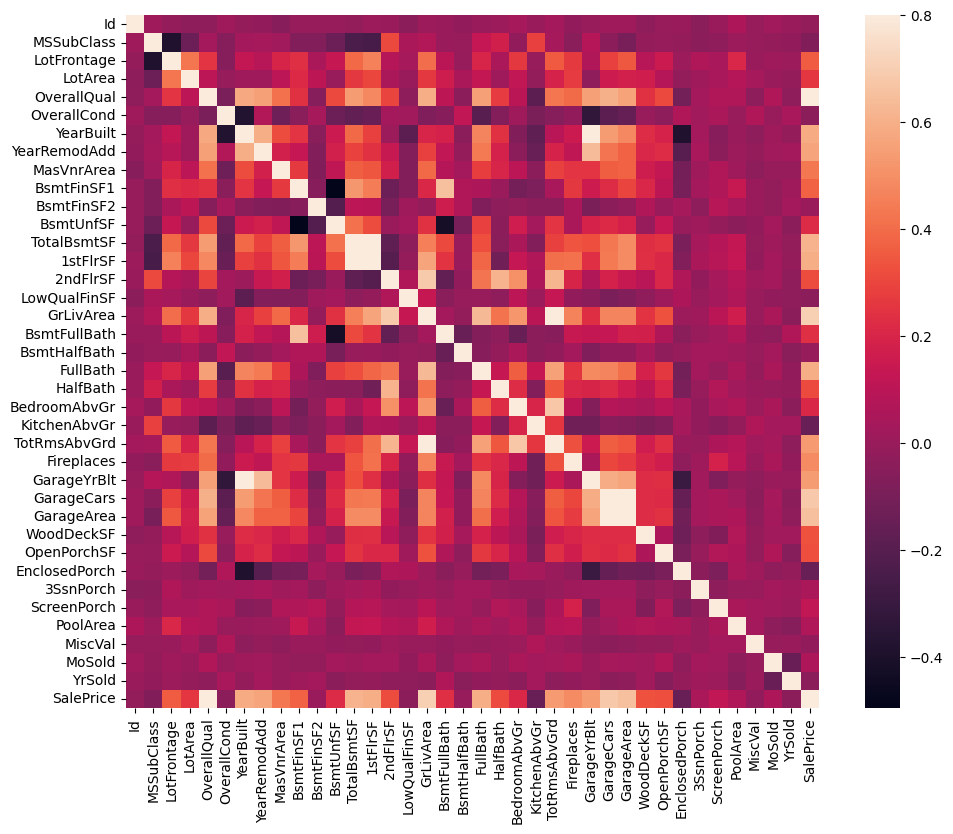

In [5]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Посмотрим на корреляцию относительно'SalePrice'

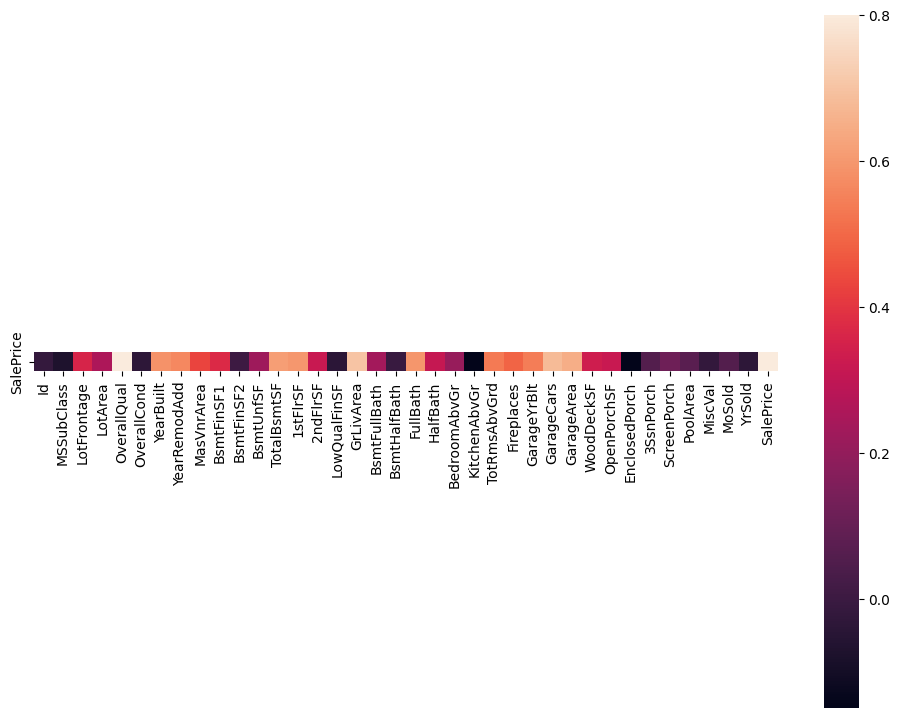

In [31]:
corr_with_saleprice = corrmat.loc[['SalePrice'], :]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_with_saleprice, vmax=0.8, square=True);


Рассмотрим поближе матрицу корреляции для 5 признаков с наиб. корреляцией

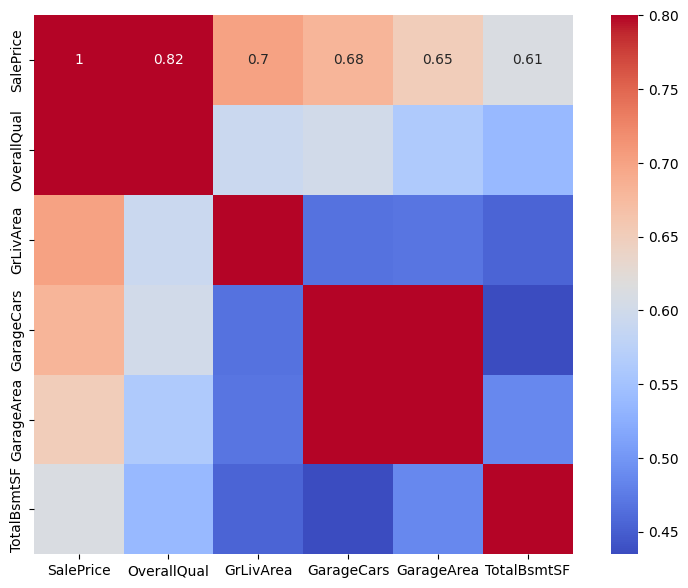

In [7]:
corr_with_saleprice_sorted = corrmat['SalePrice'].abs().sort_values(ascending=False)
top_features = corr_with_saleprice_sorted[0:6] # Выберем топ-5 признаков с наибольшей корреляцией
corr_top_features = corrmat.loc[top_features.index, top_features.index]

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr_top_features, annot=True, cmap='coolwarm', vmax=.8, square=True);


Изучи данную тепловую карту можно сделать вывод, что `SalePrice` больше всего коррелирует с `GrLivArea` и `OverallQual`

#### Построим графики рассеивания для пары этих признаков 

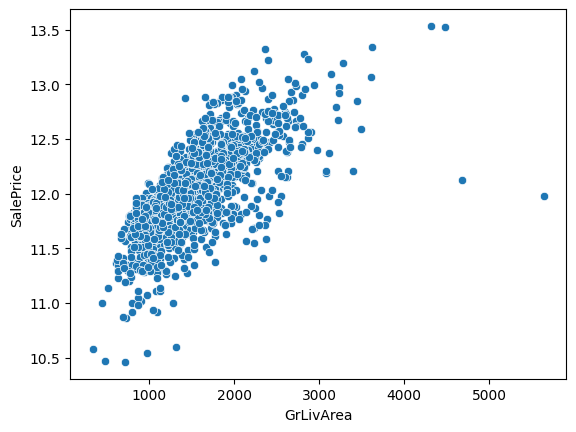

In [114]:
sns.scatterplot(data=df_train, y='SalePrice', x='GrLivArea');

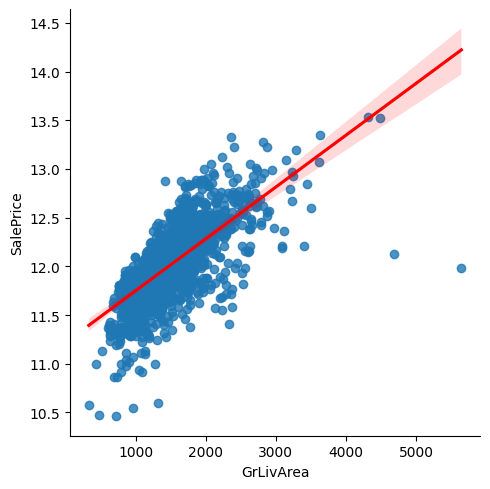

In [115]:
sns.lmplot(data=df_train, y='SalePrice', x='GrLivArea', line_kws={'color': 'red'});

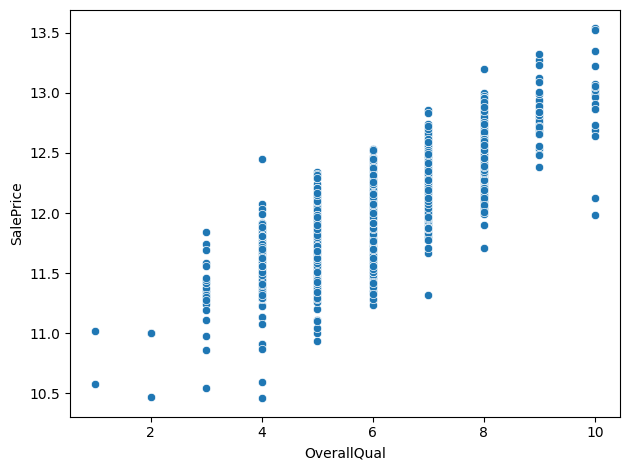

In [15]:
sns.scatterplot(data=df_train, y='SalePrice', x='OverallQual')
plt.tight_layout();

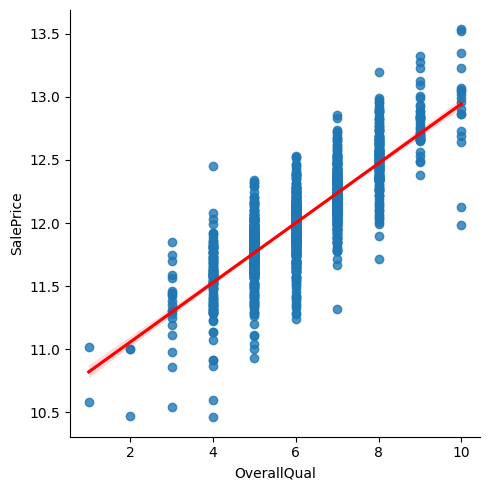

In [16]:
sns.lmplot(data=df_train, y='SalePrice', x='OverallQual', line_kws={'color': 'red'});

По графикам видно, что встречается небольшое количество выбросов, удалим несколькико, чтоб результат модели улучшился

In [116]:
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 12.5)].index)

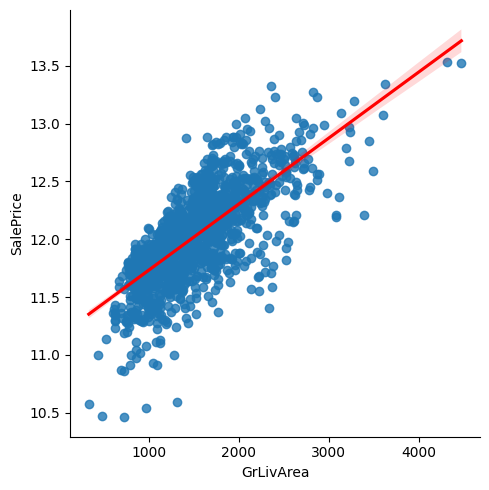

In [117]:
sns.lmplot(data=df_train, y='SalePrice', x='GrLivArea', line_kws={'color': 'red'});

#### Теперь перейдем к построению регрессионных моделей

In [160]:
X = train_data
y = Sale

Потроим модель Ridge регрессии с кросс-валидацией

In [161]:
ridge_cv = RidgeCV(alphas = (0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
ridge_cv.fit(X, y)
ridge_cv_preds = ridge_cv.predict(test_data)

Создадим объект модели XGBoost регрессора

In [162]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2)
model_xgb.fit(X, y)
xgb_preds = model_xgb.predict(test_data)

Будем использовать усредненное значение от двух моделей

In [163]:
predictions = (ridge_cv_preds + xgb_preds) / 2

In [167]:
submission = {
    'Id': df_test.Id.values,
    'SalePrice': predictions
}
sub = pd.DataFrame(submission)
sub.to_csv('submission.csv',index=False)